## Explaining Detection Scores with Explain Anything
In this notebook, we will be using Explain Anything to interpret and understand the detection scores of an object detection model.

In [1]:
import sys
sys.path.insert(0, '/app/')

from PIL import Image

import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from explain_anything.segmenter import BboxSegmenter

### Instantiating our feature segmentation
Here, we are firstly interested in separating the different features into masks.

As this involves object detection, we will be using `BboxSegmenter` over `FeatureSegmenter`. This will allow us to focus on the actual bounding-box-cropped views of the image, rather than the entire image, allowing the few shot segmentation model (SegGPT) to be much more accurate.

In [2]:
bbox_segmenter = BboxSegmenter(
	seggpt_checkpoint = '/seggpt_vit_large.pth',
	feature_count = 3 # We have a total of three features, the tail, the body, and the head.
)

[SegGPT] Model Loaded


Now, we'll be adding in our support data. A variable number of support data can be added, with more support data leading to better results. Note, we pass along:
1. **Image**: the exact image we work with
2. **Mask**: an png. `1` should represent the first feature, `2` should represent the second, `3` should repersent the third.
3. **Label**: a text file for bounding boxes in YOLO format, or a 2d list representing.

To understand this better, let's take a look at this data. I have labelled a total of 10 images, so let's take a look at one of them:

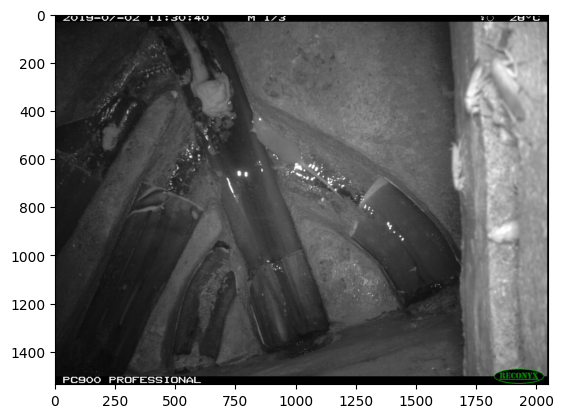

In [3]:
plt.imshow(Image.open('/app/examples/detection/rats/images/train/scene3 (1).jpg'))

We see there appears to be a rat in the center, our ground truth mask should capture this. Let's take a look at the mask as well.

Unique values: [0 1 2 3]


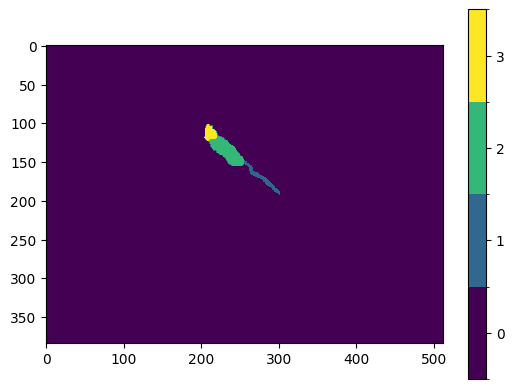

In [4]:
import matplotlib.colors as mcolors

# Define discrete colormap
cmap = plt.cm.get_cmap('viridis', 4)  # 10 discrete colors
bounds = np.arange(-0.5, 4, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.imshow(np.array(Image.open(f"/app/examples/detection/rats/masks/scene3 (1).png")), cmap = cmap, norm = norm)
print("Unique values:", np.unique(np.array(Image.open(f"/app/examples/detection/rats/masks/scene3 (1).png"))))

# Create a colorbar with integer labels
cbar = plt.colorbar(ticks=np.arange(0, 4))

We see as expected a mask indicating the location of the rat in the image with:
- `0` representing background
- `1` representing our first feature (tail)
- `2` representing our second feature (body)
- `3` representing our third feature (head)

Lastly, we take a look at our labels. As in YOLO format, we observe the values to be:
`<object class> <center x> <center y> <width> <height>`

In [5]:
with open(f"/app/examples/detection/rats/labels/train/scene3 (1).txt", "r") as f:
	print(f.read())

0 0.49169921875 0.38671875 0.19921875 0.25390625


Now that we've understood our data, let's add the support for our few shot model to learn from!

In [3]:
for num in [1, 2, 16, 18, 19, 27, 46, 77, 91]: # <- These are a variety of images I manually hand labelled
	bbox_segmenter.add_support_data(
		image_path = f"/app/examples/detection/rats/images/train/scene3 ({num}).jpg",
		mask_path = f"/app/examples/detection/rats/masks/scene3 ({num}).png",
		labels = f"/app/examples/detection/rats/labels/train/scene3 ({num}).txt"
	)

Alternatively, if YOLO format is inconvenient to follow for the labels, you can also add the labels directly.

In [7]:
bbox_segmenter.reset_support_data()

labels = []
for num in [1, 2, 16, 18, 19, 27, 46, 77, 91]:
	with open(f"/app/examples/detection/rats/labels/train/scene3 ({num}).txt", "r") as file:
		bbox = file.readline().rstrip().split(' ')[1:]
		bbox = list(map(float, bbox))
		print("Adding:", bbox)
		labels.append(bbox)

print("Final labels:", labels)

Adding: [0.49169921875, 0.38671875, 0.19921875, 0.25390625]
Adding: [0.486083984375, 0.3694661458333333, 0.21923828125, 0.22591145833333334]
Adding: [0.533935546875, 0.65625, 0.12353515625, 0.3255208333333333]
Adding: [0.19921875, 0.3961588541666667, 0.21875, 0.107421875]
Adding: [0.275634765625, 0.4466145833333333, 0.23681640625, 0.08723958333333333]
Adding: [0.204833984375, 0.40234375, 0.21240234375, 0.13020833333333334]
Adding: [0.287353515625, 0.6350911458333334, 0.17626953125, 0.2975260416666667]
Adding: [0.50830078125, 0.3857421875, 0.189453125, 0.146484375]
Adding: [0.58740234375, 0.6494140625, 0.240234375, 0.240234375]
Final labels: [[0.49169921875, 0.38671875, 0.19921875, 0.25390625], [0.486083984375, 0.3694661458333333, 0.21923828125, 0.22591145833333334], [0.533935546875, 0.65625, 0.12353515625, 0.3255208333333333], [0.19921875, 0.3961588541666667, 0.21875, 0.107421875], [0.275634765625, 0.4466145833333333, 0.23681640625, 0.08723958333333333], [0.204833984375, 0.40234375, 0.

In [8]:
for num in [1, 2, 16, 18, 19, 27, 46, 77, 91]:
	bbox_segmenter.add_support_data(
		image_path = f"/app/examples/detection/rats/images/train/scene3 ({num}).jpg",
		mask_path = f"/app/examples/detection/rats/masks/scene3 ({num}).png",
		labels = labels
	)

Once we have our support data loaded in, let's see how well we are able to segment out a new unseen image.

In [4]:
i = 101

mask = bbox_segmenter.generate_segmentation(
	f"/app/examples/detection/rats/images/train/scene3 ({i}).jpg",
	f"/app/examples/detection/rats/labels/train/scene3 ({i}).txt",
	output_dir = '/app/examples/detection/rats/predicted_masks',
	pixel_threshold = 80
)

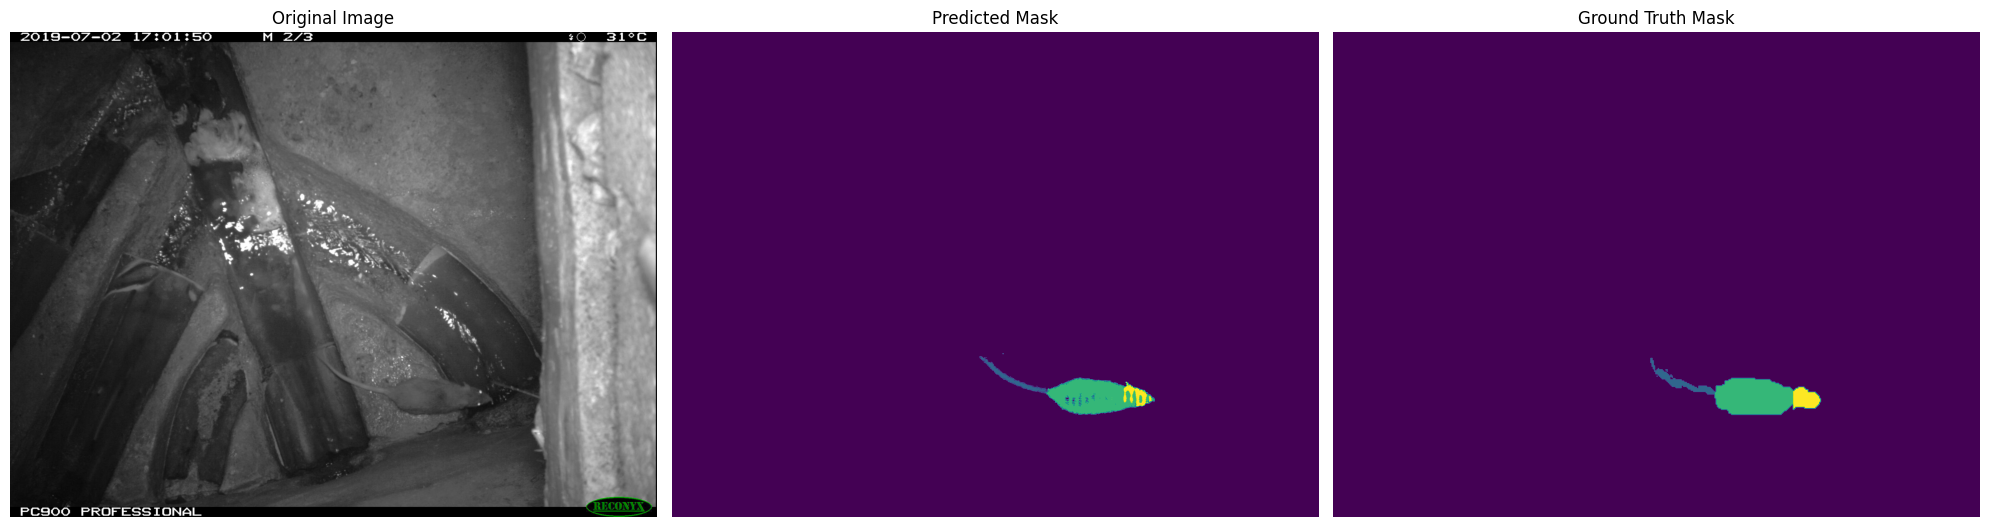

In [5]:
fig = plt.figure(figsize=(20, 40))
ax = fig.subplots(1, 3)

img = np.array(Image.open(f"/app/examples/detection/rats/images/train/scene3 (101).jpg"))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].set_title("Predicted Mask")
ax[1].imshow(mask)
ax[1].axis('off')
ax[2].imshow(Image.open('/app/examples/detection/rats/masks_gt/scene3 (101).png'))
ax[2].axis('off')
ax[2].set_title("Ground Truth Mask")

fig.tight_layout()

Now that we know it works, we will proceed with generating these masks for the rest of the dataset

In [16]:
# NOTE: This can be very expensive to run and may take long, as few shot segmentation is being performed
# N x F times, where N is the number of images and F is the number of features.
from tqdm import tqdm

for i in tqdm(range(1, 225)):
	mask = bbox_segmenter.generate_segmentation(
		f"/app/examples/detection/rats/images/train/scene3 ({i}).jpg",
		f"/app/examples/detection/rats/labels/train/scene3 ({i}).txt",
		output_dir = '/app/examples/detection/rats/predicted_masks',
		pixel_threshold = 80
	)

100%|██████████| 224/224 [07:51<00:00,  2.10s/it]


### Object Detection Model
Let's load in our trained object detection model. Below are some adapter functions that will allow us to use ultralytics YOLO with our pipeline.

In [3]:
from ultralytics import YOLO
import torch
import torch.nn as nn

class AdaptorModel(nn.Module):
	def __init__(self):
		super(AdaptorModel, self).__init__()

	def pil_to_tensor(self, pil_image):
		np_img = np.array(pil_image)
		np_img = cv2.resize(np_img, [640, 480])
		tensor = torch.tensor(np_img).permute(2, 0, 1).unsqueeze(0)
		return tensor.float() / 255.0  # Normalizing to [0, 1]

	def forward(self, x):
		# Handling different types of input
		if isinstance(x, Image.Image):
			x = self.pil_to_tensor(x)
		elif isinstance(x, str):  # Assuming it's a filepath
			x = self.pil_to_tensor(Image.open(x))
		elif isinstance(x, torch.Tensor) and torch.max(x).item() > 1.0:
			x = x.float() / 255.0  # Normalizing to [0, 1]
		
		return x.expand(-1, 3, -1, -1)  # Expanding the single channel to 3 channels


class MyModel(YOLO):
	def __init__(self, confidence_mode = False, verbose = True, *args, **kwargs):
		super(MyModel, self).__init__(*args, **kwargs)
		self.confidence_mode = confidence_mode
		self.adaptor = AdaptorModel()
		self.verbose = verbose

	def __call__(self, *args, **kwargs):
		# Convert 1 channel to 3 channels using the adaptor
		args = list(args)
		args[0] = self.adaptor(args[0])
		
		result = super().__call__(verbose = self.verbose, *args, **kwargs)
		if self.confidence_mode:
			confidence = (torch.tensor([torch.nan_to_num(torch.mean(torch.nan_to_num(r.boxes.conf))) for r in result]))
			# print('confidence:', confidence)
			return confidence
		else:
			return result

Let's test it out, we only want the confidence score as the output, as that will be what Explain Anything will use.

In [4]:
model = MyModel(
	True, # To only return confidence score
	False, # No verbose
	'/app/examples/detection/best.pt',
)

model('/app/examples/detection/rats/images/train/scene3 (101).jpg')

tensor([0.8937])

tensor(0.)


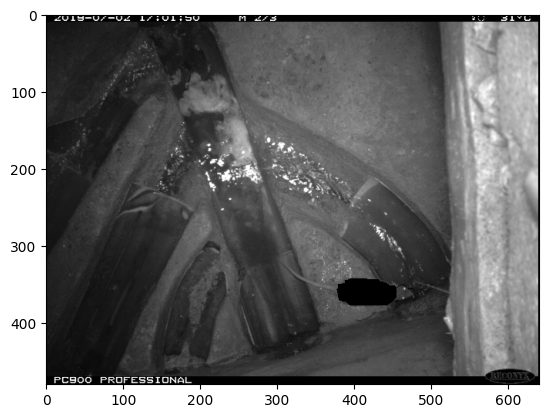

In [13]:
# NOTE: Sanity check for feature ablation
# import torchvision.transforms as transforms 

# image = Image.open('/app/examples/detection/rats/images/train/scene3 (101).jpg')
# mask = Image.open('/app/examples/detection/rats/masks_gt/scene3 (101).png')
  
# # Define a transform to convert PIL  
# # image to a Torch tensor 
# transform = transforms.Compose([ 
#     transforms.PILToTensor(),
# 	transforms.Resize((480, 640))
# ]) 
  
# # transform = transforms.PILToTensor() 
# # Convert the PIL image to Torch tensor 
# img_tensor = transform(image).float()
# img_tensor = img_tensor.mean(dim = 0)

# mask_tensor = torch.tensor(np.array(mask.convert('RGB'))).permute((2, 0, 1))
# mask_tensor = transforms.Resize((480, 640))(mask_tensor).float()
# mask_tensor = mask_tensor.mean(dim = 0)


# # baseline = torch.tensor(np.random.rand(*img_tensor.shape) * 255).float()
# baseline = torch.tensor(np.full(img_tensor.shape, 0)).float()

# img_tensor[mask_tensor == 2] = baseline[mask_tensor == 2]
# img_tensor = img_tensor.unsqueeze(0)

# plt.imshow(
# 	img_tensor.permute(1, 2, 0).cpu().numpy() , cmap='gray'
# )
# # mask_tensor = mask_tensor.unsqueeze(0)
# print(model(img_tensor.unsqueeze(0))[0])


### Explain Anything
With all the features set up and model loaded in, we'll now look at how to use Explain Anything to interpret the model across the whole dataset. Let's first instantiate the model, as well as define the feature names:

In [5]:
import sys
sys.path.insert(0, '/app/')

from explain_anything.explain import ExA

exa = ExA()
features = ['tail', 'body', 'head']

Next, we'll return the ablation and see what the results look like!

In [6]:
def custom_baseline(mask_batch_shape):
	return torch.tensor(np.full(mask_batch_shape, 0)).float().cuda()
	# return torch.tensor((np.random.rand(*mask_batch_shape) * 255).astype(np.uint8)).to('cuda')

Using SegGPT segmentation:

In [7]:
scores = exa.ablate(
    model,
    '/app/examples/detection/rats/images/train',
    '/app/examples/detection/rats/predicted_masks/',
    features,
	batch_size = 1,
	num_workers = 0,
	custom_baseline = custom_baseline,
    grayscale = True
)

for s, f in list(sorted(zip(scores, ['background'] + features)))[::-1]:
    print(f, s)

100%|██████████| 224/224 [00:46<00:00,  4.85it/s]

background 0.7664760984905971
body 0.09814791108174274
tail 0.09618378498752794
head 0.03919220544013209


Using ground truth masks (note the number of images are **vastly** different):

In [15]:
scores = exa.ablate(
    model,
    # '/app/examples/detection/rats/images/train',
    # '/app/examples/detection/rats/output_masks/',
    '/app/examples/detection/rats/images/truth',
    '/app/examples/detection/rats/masks_gt/',
    # '/app/examples/detection/rats/test/truth',
    # '/app/examples/detection/rats/test/masks_gt/',
    features,
	batch_size = 1,
	num_workers = 0,
	custom_baseline = custom_baseline,
    grayscale = True
)

for s, f in list(sorted(zip(scores, ['background'] + features)))[::-1]:
    print(f, s)

  0%|          | 0/224 [00:00<?, ?it/s]

100%|██████████| 224/224 [00:46<00:00,  4.78it/s]

background 0.7227302795545781
tail 0.11828793709448397
body 0.09512841782808909
head 0.06385336552284879


We observe that the background seems to have a lot of weightage, this likely suggests that the shape of the rat (the intersection between the background and the border of the rat) appears to have much more importance, as when the background is set to 0, the score drops heavily. 